# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

# LIBS

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting 
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import DiscreteAllocation


from itertools import combinations

# DATA

### tickers

In [56]:
sectors_yahoo = {"bigtech": "^SP500-45", "staples": "^SP500-30", "energy": "^GSPE", "finance": "^SP500-20", "health": "^SP500-35", "discretionary": "^SP500-25", "real estate": "^SP500-60"}
sectors_yahoo_reverse = {'^SP500-45': 'bigtech',
 '^SP500-30': 'staples',
 '^GSPE': 'energy',
 '^SP500-20': 'finance',
 '^SP500-35': 'health',
 '^SP500-25': 'discretionary',
 '^SP500-60': 'real estate'}
sectors = ["bigtech", "staples", "energy", "finance", "health", "discretionary", "real estate"]

tickers = []
for key in sectors_yahoo:
    if (key in sectors) :
        tickers.append(sectors_yahoo[key])
tickers


['^SP500-45',
 '^SP500-30',
 '^GSPE',
 '^SP500-20',
 '^SP500-35',
 '^SP500-25',
 '^SP500-60']

### load market data

In [57]:
ohlc = yf.download(tickers, interval="1wk", period="5y")
prices = ohlc["Adj Close"]
prices.tail()

market_prices = yf.download("SPY", period="5y", interval="1wk")["Adj Close"]
market_prices.head()

mcaps = {}
for t in tickers:
    # stock = yf.Ticker(t)
    mcaps[t] = yf.download(t, period="5y", interval="1wk")["Volume"].sum()

[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### count profitabilities

In [70]:
# Недельные доходности
returns = prices.pct_change().dropna()

# Годовые доходности по годам
sector_returns = returns.groupby(returns.index.year).apply(lambda x: (1 + x).prod() - 1)

average_weekly_return = returns.mean()  # Средняя недельная доходность для каждого тикера
average_annual_return = (1 + average_weekly_return) ** 52 - 1
average_annual_return

^GSPE        0.163560
^SP500-20    0.136363
^SP500-25    0.146258
^SP500-30    0.081026
^SP500-35    0.110929
^SP500-45    0.276247
^SP500-60    0.065904
dtype: float64

# Constructing the prior

In [59]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.8236215708989096

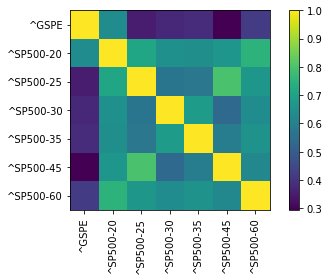

In [60]:
plotting.plot_covariance(S, plot_correlation=True);

In [61]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

^GSPE        0.828861
^SP500-20    0.789606
^SP500-25    0.810605
^SP500-30    0.459975
^SP500-35    0.530209
^SP500-45    0.825079
^SP500-60    0.777364
dtype: float64

<AxesSubplot:>

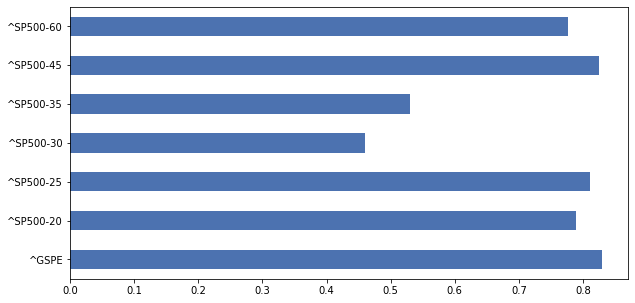

In [62]:
market_prior.plot.barh(figsize=(10,5))

# Views

## MATRIX P AND Q

In [118]:
# You don't have to provide views on all the assets

tickers = []
for key in sectors_yahoo:
    if (key in sectors) :
        tickers.append(sectors_yahoo[key])
tickers

viewdict = {
    
}

viewdict = {
    '^SP500-45': 1.9859/5,
    '^SP500-30': 0.3716/5,
    '^GSPE': 0.5048/5, 
    '^SP500-20': 0.6038/5,
    '^SP500-35': 0.564/5, 
    '^SP500-25': 0.6884/5,
    '^SP500-60': 0.1072/5,
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=average_annual_return)

# View confidences

In [119]:
mean_returns = sector_returns.mean()
std_devs = sector_returns.std()

# # std_devs

# Создаем таблицу с результатами
volatility_data = pd.DataFrame({
    "Mean Return": mean_returns,
    "Volatility (Std Dev)": std_devs
})

import ace_tools_open as tools; tools.display_dataframe_to_user(name="5-Year Volatility Data", dataframe=volatility_data)   

# Задаем секторы с повышенной уверенностью
confident_sectors = ["^SP500-45", "^SP500-35"]  # Пример секторов, в которых больше уверенности
confidence_factor = 0.7  # Коэффициент для секторов с большей уверенностью

# Создаем интервалы с учетом уверенности
intervals = [
    (
        round(
            volatility_data.loc[ticker, "Mean Return"] - 
            (confidence_factor if ticker in confident_sectors else 1) * volatility_data.loc[ticker, "Volatility (Std Dev)"], 4
        ),
        round(
            volatility_data.loc[ticker, "Mean Return"] + (confidence_factor if ticker in confident_sectors else 1) * volatility_data.loc[ticker, "Volatility (Std Dev)"], 4
        )
    )
    for ticker in tickers
]
intervals


5-Year Volatility Data


[(0.0205, 0.442),
 (-0.021, 0.1374),
 (-0.2321, 0.4801),
 (-0.0136, 0.1971),
 (0.0129, 0.1488),
 (-0.1519, 0.4056),
 (-0.1843, 0.2752)]

In [120]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)
omega

[0.0444155625, 0.006272639999999999, 0.12680721000000003, 0.0110986225, 0.0046172025, 0.0777015625, 0.05278506250000001]


array([[0.04441556, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.00627264, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.12680721, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01109862, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0046172 ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.07770156, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.05278506]])

## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [121]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega = omega)

In [122]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

We can visualise how this compares to the prior and our views:

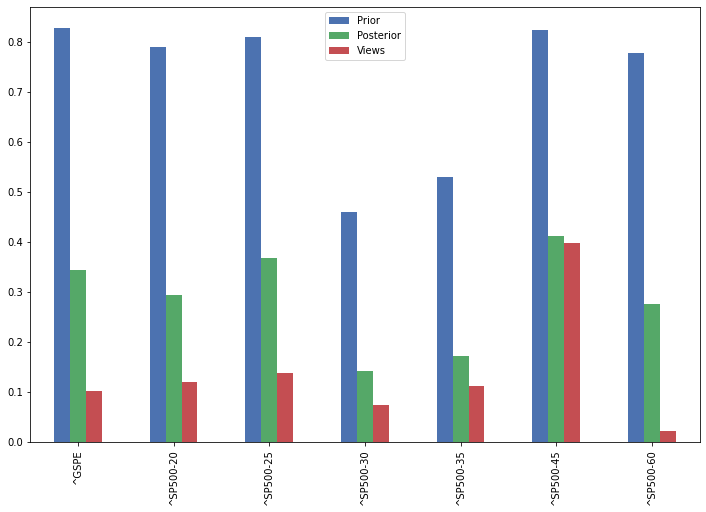

In [123]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

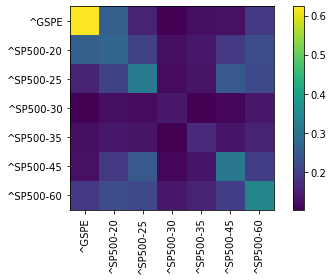

In [124]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [132]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
# ef.max_sharpe()
weights = ef.efficient_return(0.15)
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)

print(expected_return)
ef.clean_weights()
weights

Expected annual return: 27.1%
Annual volatility: 41.0%
Sharpe Ratio: 0.61
0.27074650673190676


c:\Users\roman\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


OrderedDict([('^GSPE', 0.1126232166580292),
             ('^SP500-20', 0.125585198414079),
             ('^SP500-25', 0.1275549787823938),
             ('^SP500-30', 0.1978617882226836),
             ('^SP500-35', 0.1829745440684916),
             ('^SP500-45', 0.1360193420638403),
             ('^SP500-60', 0.1173809317904824)])

In [129]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
weights

Expected annual return: 33.7%
Annual volatility: 46.4%
Sharpe Ratio: 0.68


OrderedDict([('^GSPE', 0.17148),
             ('^SP500-20', 0.13183),
             ('^SP500-25', 0.21473),
             ('^SP500-30', 0.03763),
             ('^SP500-35', 0.05871),
             ('^SP500-45', 0.27715),
             ('^SP500-60', 0.10848)])

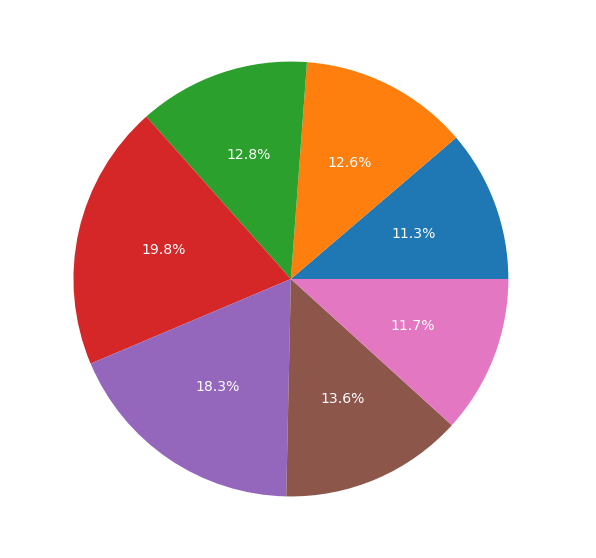

In [139]:
pd.Series(weights).plot.pie(
    figsize=(10,10), 
    labels = [sectors_yahoo_reverse['^GSPE'], sectors_yahoo_reverse['^SP500-20'], sectors_yahoo_reverse['^SP500-25'], sectors_yahoo_reverse['^SP500-30'], sectors_yahoo_reverse['^SP500-35'], sectors_yahoo_reverse['^SP500-45'], sectors_yahoo_reverse['^SP500-60']],
    autopct='%1.1f%%',
    textprops={'fontsize': 14, 'color': 'white'},
    colors=plt.cm.tab10.colors
);

In [ ]:



da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $267.21


c:\Users\roman\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'^SP500-20': 3,
 '^SP500-25': 2,
 '^SP500-30': 3,
 '^SP500-35': 2,
 '^SP500-45': 1,
 '^SP500-60': 10}